## Downloading Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"723560b7185be5319834d0625e95abc5"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d romainpessia/artificial-lunar-rocky-landscape-dataset

100% 5.02G/5.02G [04:32<00:00, 23.5MB/s]
100% 5.02G/5.02G [04:32<00:00, 19.8MB/s]


In [4]:
!unzip -qq -o /content/artificial-lunar-rocky-landscape-dataset.zip

## Importing Libraries 

In [28]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.style.use('ggplot')

In [2]:
# !pip -q install tf-explain

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dropout, Input, MaxPool2D, BatchNormalization, UpSampling2D, concatenate, Add, Multiply
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.utils import plot_model

## Loading Data

In [4]:
images_dic = '/content/images/render'
masks_dic = '/content/images/clean'
images_path = sorted(os.listdir(images_dic))[:2000]
masks_path = sorted(os.listdir(masks_dic))[:2000]

## Data Visualization

In [5]:
def show_mask(image_path, mask_path, alpha, title='', cmap=None):  
  plt.imshow(image)
  plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
  if title is not None:
    plt.title(title)
  plt.axis('off')

In [11]:
def show_image(image, title='', cmap = None):
  plt.imshow(image, cmap=cmap, alpha=1)
  if title is not None:
    plt.title(title)
  plt.axis('off')

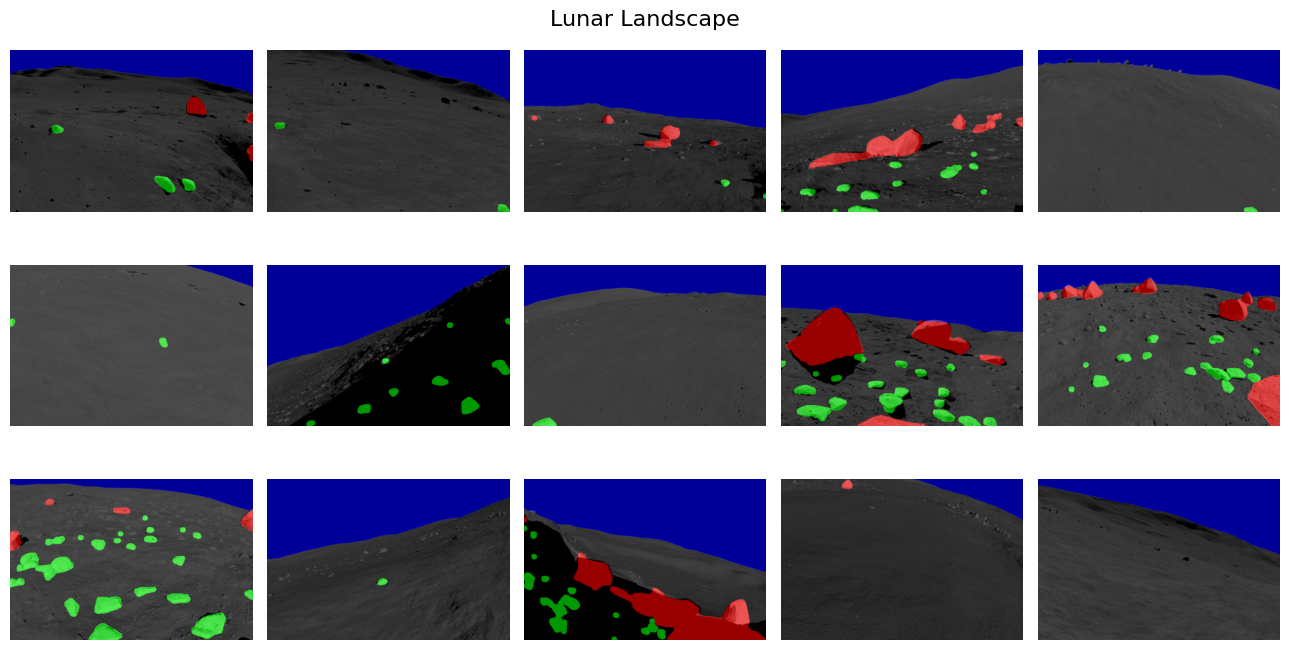

In [6]:
plt.figure(figsize=(13,7))
for i in range(15):
  plt.subplot(3,5,i+1)
  id = np.random.randint(len(images_path))
  image_path = images_dic + '/' +  images_path[id]
  mask_path = masks_dic + '/' + masks_path[id]
  image = cv2.imread(image_path)  
  mask = cv2.imread(mask_path) 
  show_mask(image, mask, alpha=0.6, cmap='gist_heat')
plt.tight_layout()
plt.suptitle('Lunar Landscape', size=16)
plt.show()

## Dataset Building

In [7]:
def build_dataset(images_path, masks_path, img_height, img_width, img_size):
  X = np.zeros((len(images_path), img_height, img_width, 3), dtype=np.uint8).astype(np.float32)
  y = np.zeros((len(masks_path), img_height, img_width, 1), dtype=np.uint8).astype(np.float32)

  for i, (image, mask) in tqdm(enumerate(zip(images_path, masks_path))):
    image_path = images_dic + '/' +  image
    mask_path = masks_dic + '/' + mask
    img = cv2.imread(image_path, 1)
    img = cv2.resize(img, (img_size, img_size))
    img = np.expand_dims(img, axis=0)
    img = img.reshape(1, img_height, img_width, 3)
    img = img / 255.
    X[i] = img
    
    msk = cv2.imread(mask_path, 1)
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    msk = cv2.resize(msk, (img_size, img_size))
    msk = np.expand_dims(msk, axis=0)
    msk = msk.reshape(1, img_height, img_width, 1)
    msk = msk / 255.
    y[i] = msk
    
  return X, y 

In [8]:
img_height = 256
img_width = 256
img_size = 256
X, y = build_dataset(images_path, masks_path, img_height, img_width, img_size)

0it [00:00, ?it/s]

In [9]:
print(X.shape)
print(y.shape)

(2000, 256, 256, 3)
(2000, 256, 256, 1)


## Splitting The Data

In [10]:
from sklearn.model_selection import train_test_split
X_train_test, X_vali, y_train_test, y_vali = train_test_split(X, y, test_size=0.2)

## Construction of Attention U-Net

In [12]:
class EncoderBlock(Layer):
  def __init__(self, filters, rate, pooling=True, **kwargs):
    super(EncoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.rate = rate
    self.pooling = pooling

    self.cnn1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
    self.dropout = Dropout(rate)
    self.cnn2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
    self.pool = MaxPool2D()

  def call(self, X):
      x = self.cnn1(X)
      x = self.dropout(x)
      x = self.cnn2(x)
      if self.pooling:
          y = self.pool(x)
          return y, x
      else:
          return x

  def get_config(self):
      base_config = super().get_config()
      return {
          **base_config,
          "filters":self.filters,
          'rate':self.rate,
          'pooling':self.pooling
      }

In [13]:
class DecoderBlock(Layer):
  def __init__(self, filters, rate, **kwargs):
    super(DecoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.rate = rate

    self.upsampling2d = UpSampling2D()
    self.encodeblock = EncoderBlock(filters, rate, pooling=False)

  def call(self, X):
    X, skip_X = X
    x = self.upsampling2d(X)
    c_ = concatenate([x, skip_X])
    x = self.encodeblock(c_)
    return x

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        'rate':self.rate,
    }

In [14]:
class AttentionGate(Layer):
  def __init__(self, filters, bn, **kwargs):
    super(AttentionGate, self).__init__(**kwargs)

    self.filters = filters
    self.bn = bn

    self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
    self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
    self.resample = UpSampling2D()
    self.BN = BatchNormalization()

  def call(self, X):
    X, skip_X = X

    x = self.normal(X)
    skip = self.down(skip_X)
    x = Add()([x, skip])
    x = self.learn(x)
    x = self.resample(x)
    f = Multiply()([x, skip_X])
    if self.bn:
      return self.BN(f)
    else:
      return f

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        "bn":self.bn
    }

In [15]:
input_layer = Input(shape=X.shape[-3:])

In [16]:
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

In [17]:
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

In [18]:
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

In [19]:
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

## Loading The Model

In [20]:
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

## Compiling The Model

In [21]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=3, name='IoU')]
)

In [22]:
cb = [
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True)
]

## Model Visualization 

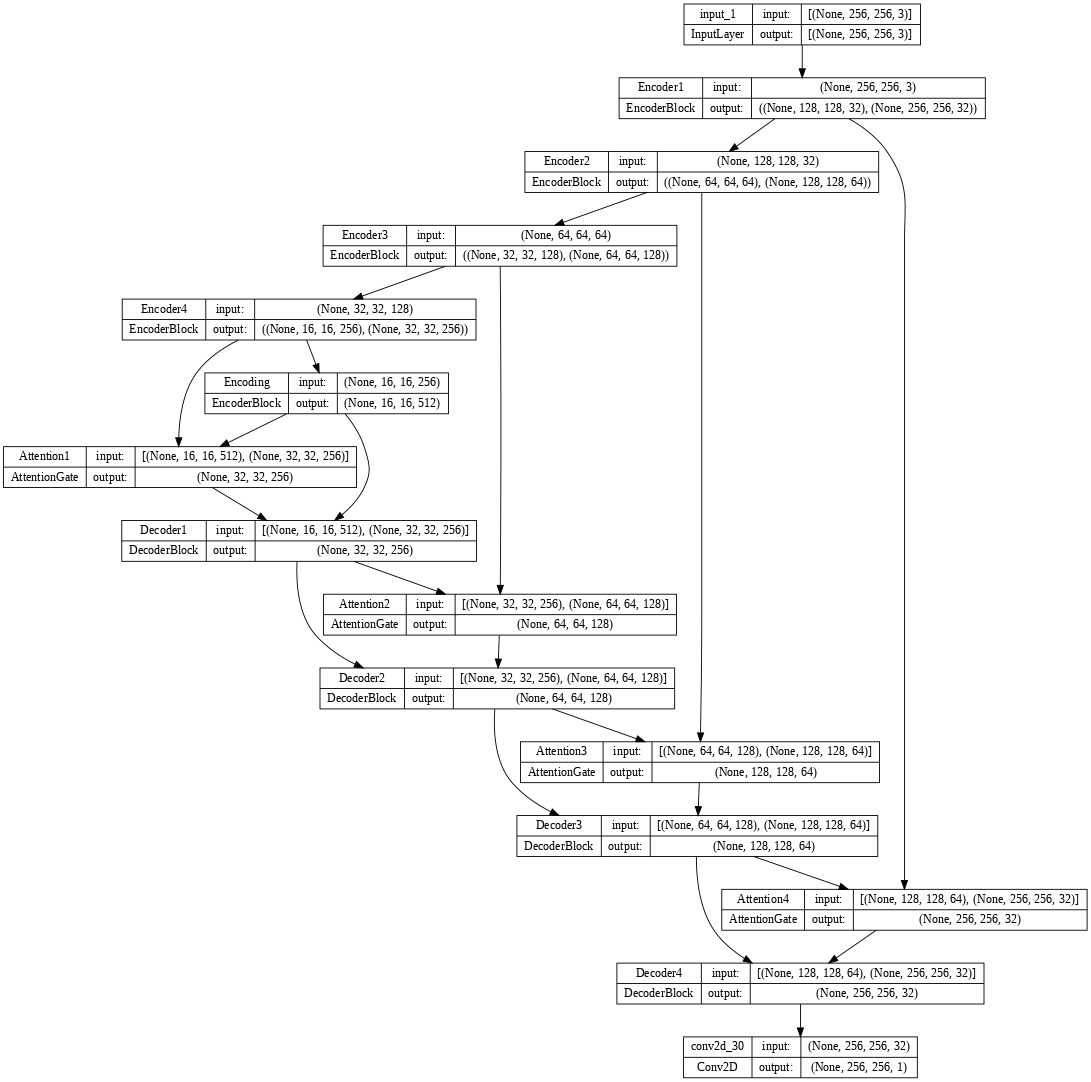

In [23]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

In [24]:
BATCH_SIZE = 6  
SPE = len(X)//BATCH_SIZE

## Model Training

In [25]:
results = model.fit(
    X_train_test, y_train_test,
    validation_split=0.2,
    epochs=12,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

Epoch 1/20
333/333 [==============================] - 110s 236ms/step - loss: 0.3761 - accuracy: 0.7565 - IoU: 1.0000 - val_loss: 0.2074 - val_accuracy: 0.7571 - val_IoU: 1.0000
Epoch 2/20
333/333 [==============================] - 74s 221ms/step - loss: 0.1818 - accuracy: 0.7576 - IoU: 1.0000 - val_loss: 0.2016 - val_accuracy: 0.7571 - val_IoU: 1.0000
Epoch 3/20
333/333 [==============================] - 71s 214ms/step - loss: 0.1793 - accuracy: 0.7539 - IoU: 1.0000 - val_loss: 0.1857 - val_accuracy: 0.7570 - val_IoU: 1.0000
Epoch 4/20
333/333 [==============================] - 71s 214ms/step - loss: 0.1717 - accuracy: 0.7603 - IoU: 1.0000 - val_loss: 0.1784 - val_accuracy: 0.7570 - val_IoU: 1.0000
Epoch 5/20
333/333 [==============================] - 71s 212ms/step - loss: 0.1734 - accuracy: 0.7573 - IoU: 1.0000 - val_loss: 0.1918 - val_accuracy: 0.7570 - val_IoU: 1.0000
Epoch 6/20
333/333 [==============================] - 74s 221ms/step - loss: 0.1733 - accuracy: 0.7559 - IoU: 1.00

333/333 [==============================] - 61s 183ms/step - loss: 0.1684 - accuracy: 0.7563 - IoU: 1.0000 - val_loss: 0.1752 - val_accuracy: 0.7570 - val_IoU: 1.0000


## Model Evaluation

In [26]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

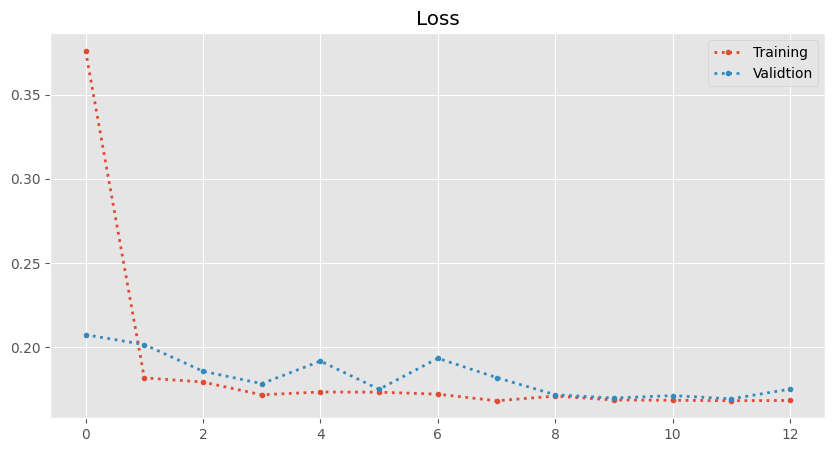

In [33]:
plt.figure(figsize=(10,5))

plt.title("Loss")
plt.plot(loss, ".:", label="Training", linewidth=2)
plt.plot(val_loss, ".:", label="Validtion", linewidth=2)
plt.legend()
plt.show()

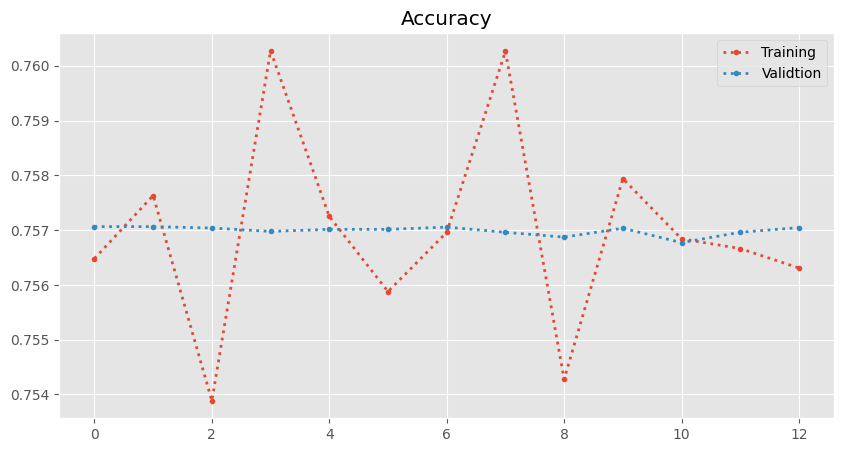

In [35]:
plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(accuracy, ".:", label="Training", linewidth=2)
plt.plot(val_accuracy, ".:", label="Validtion", linewidth=2)
plt.legend()
plt.show()

## Prediction on Validation Data

1/1 [==============================] - 0s 21ms/step


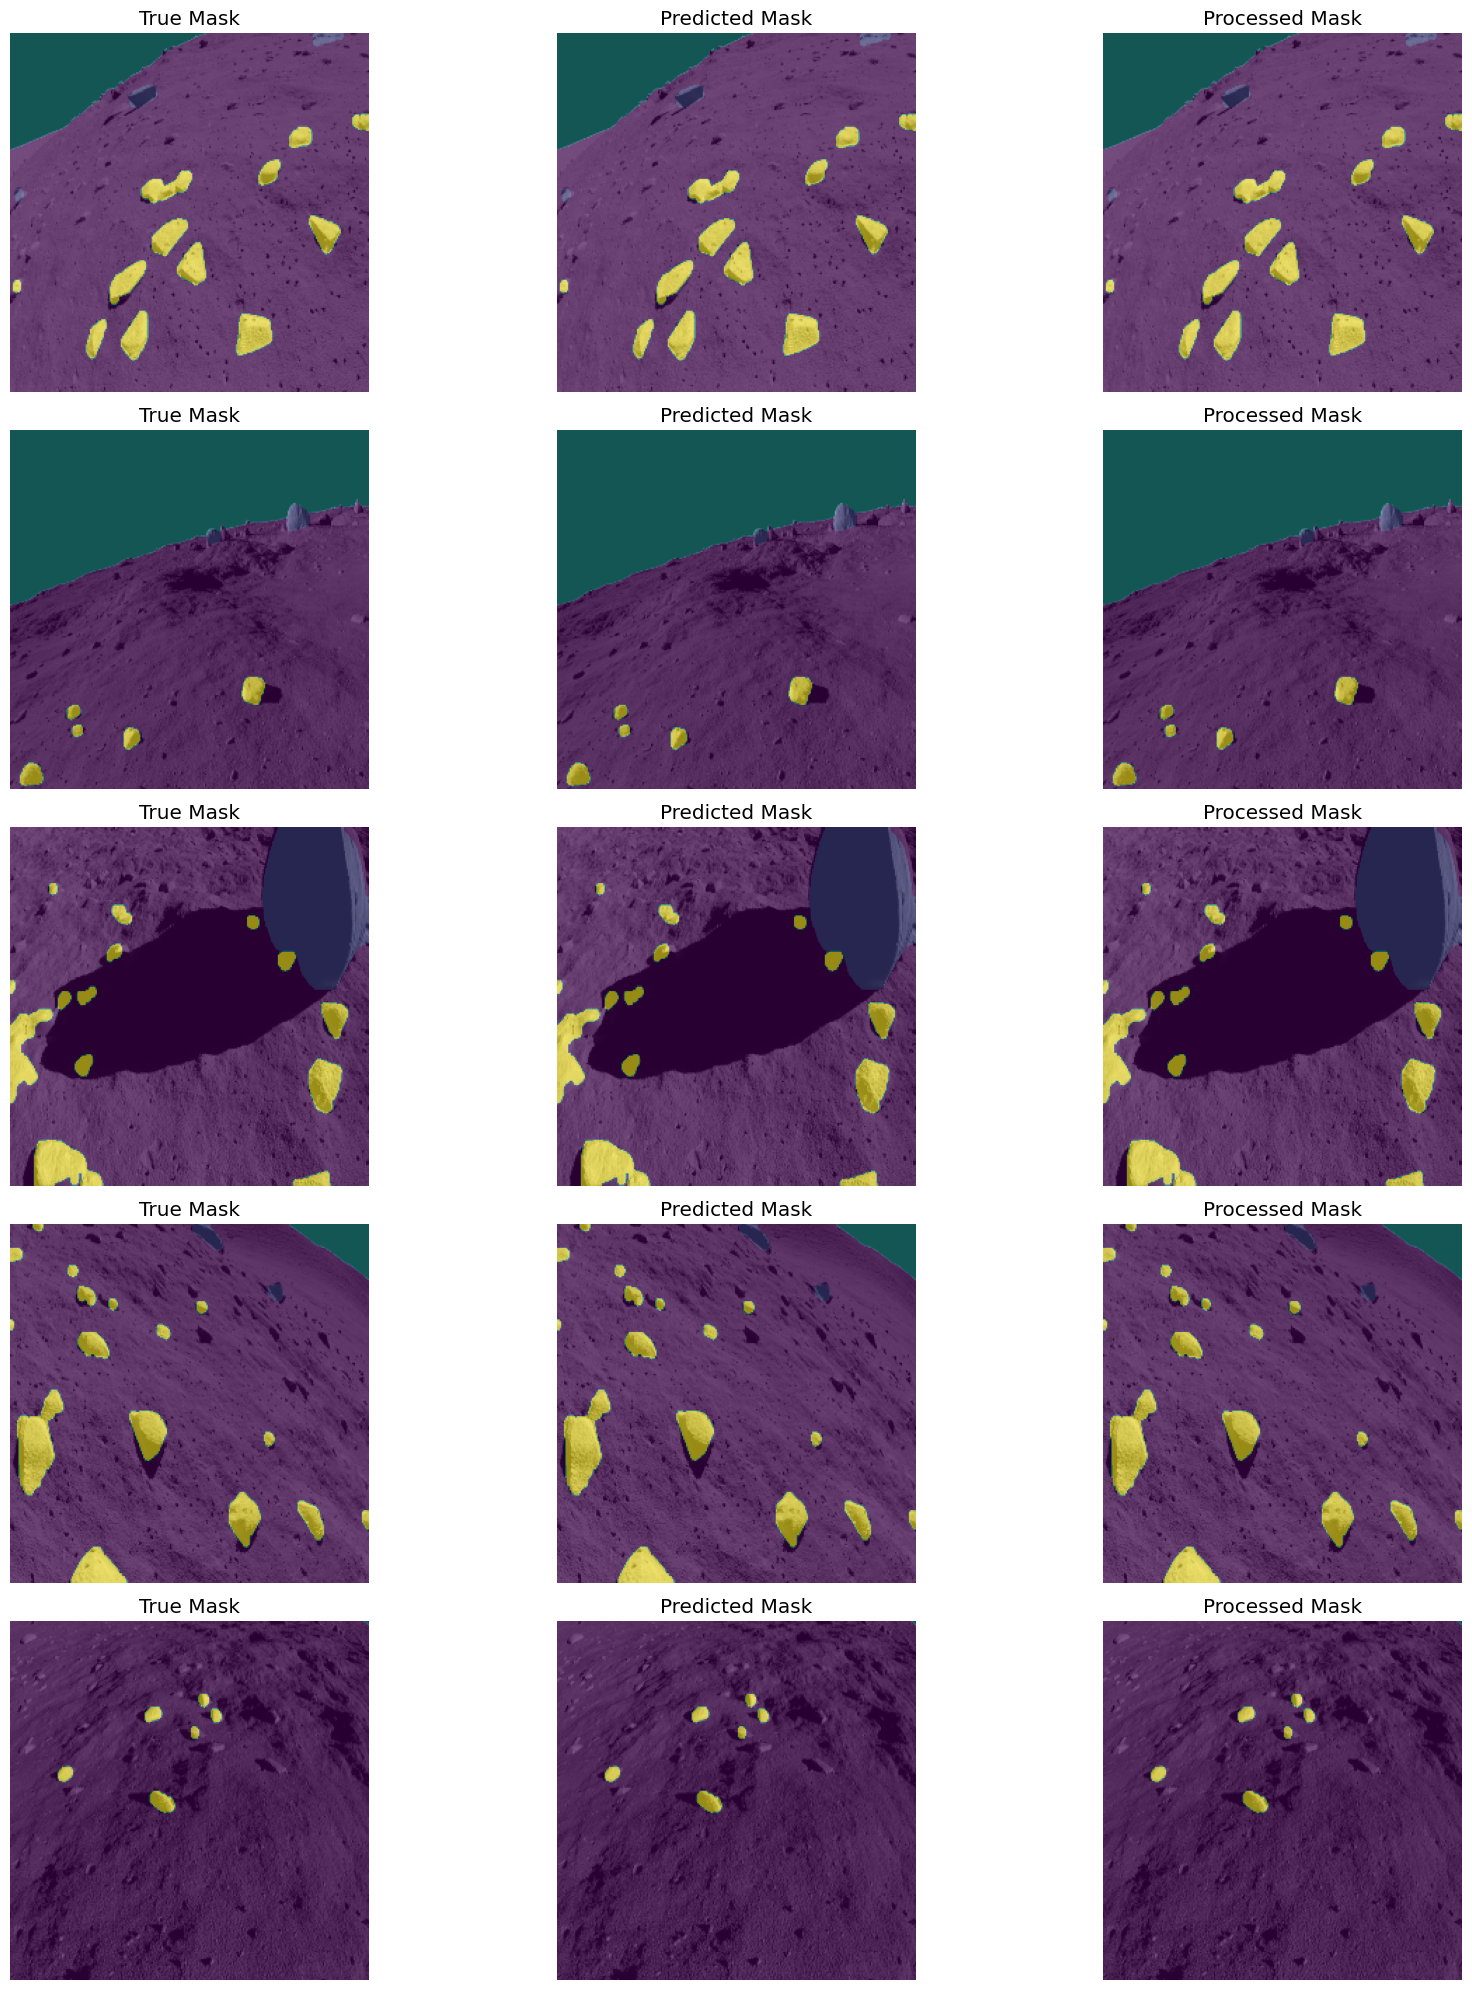

In [48]:
plt.figure(figsize=(18,20))
n=0
for i in range(1,(5*3)+1):
  plt.subplot(5,3,i)
  if n==0:
    id = np.random.randint(len(X_vali))
    image = X_vali[id]
    mask = y_vali[id]
    pred_mask = model.predict(image[np.newaxis,...])

    show_mask(image, mask, alpha=0.6,title='True Mask')
    n+=1
  elif n==1:
    show_mask(image, pred_mask, alpha=0.6, title='Predicted Mask')
    n+=1
  elif n==2:
    pred_mask = (pred_mask>0.5).astype('float')
    show_mask(image, pred_mask, alpha=0.6, title='Processed Mask')
    n=0
plt.tight_layout()
plt.show()